In [1]:
import os
import time
import shutil
import tempfile
from glob import glob
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import Dataset, DataLoader, decollate_batch, ImageDataset
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    Resized
)
from monai.utils import set_determinism

import torch
import pandas as pd
from tqdm import tqdm
#print_config()

In [2]:
columns = ['case','is_use']
positive_case = pd.read_csv('./cases/positive_case.csv', header=None, names=columns)
positive_case = positive_case[positive_case["is_use"] == 1]
positive_case["case"] = "cases/labels/" + positive_case["case"] + ".nii.gz"

file_list = []
for i in range(len(positive_case)):
    file_list.append(positive_case.iloc[i, 0])

file_list = glob('/media/mpmri/mpmri/fluke/workdir/nnUNet_raw_data/Task2213_picai_fluke/labelsTr/*.nii.gz')
print(f"{len(file_list)} images")

FileNotFoundError: [Errno 2] No such file or directory: './cases/positive_case.csv'

In [3]:
list_data  = [ {'image0':f.replace('labels','images').replace('.nii','_0000.nii'),
                'image1':f.replace('labels','images').replace('.nii','_0001.nii'),
                'image2':f.replace('labels','images').replace('.nii','_0002.nii'),
                'label':f } for f in file_list ]

In [ ]:
list_data

In [4]:
class ConvertToMultiChannel(MapTransform):
    def __call__(self, data):
        data['image'] = torch.concat([data['image0'],data['image1'],data['image2']], dim=0)
        del data['image0'], data['image1'], data['image2']
        del data['image0_meta_dict'], data['image1_meta_dict'], data['image2_meta_dict'], data['label_meta_dict']
        return data
        
train_transform = Compose(
    [
        LoadImaged(keys=["image0", "image1","image2", "label"]),
        EnsureChannelFirstd(keys=["image0", "image1","image2", "label"]),
        EnsureTyped(keys=["image0", "image1","image2", "label"]),
        ConvertToMultiChannel(keys=["image0", "image1","image2"]),
        RandSpatialCropd(keys=["image", "label"], roi_size=[120, 120, 8]),
        Resized(keys=["image", "label"], spatial_size=[240, 240, 16], mode=['area', 'nearest']),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)

valid_transform = Compose(
    [
        LoadImaged(keys=["image0", "image1","image2", "label"]),
        EnsureChannelFirstd(keys=["image0", "image1","image2", "label"]),
        EnsureTyped(keys=["image0", "image1","image2", "label"]),
        ConvertToMultiChannel(keys=["image0", "image1","image2"]),
        Resized(keys=["image", "label"], spatial_size=[512, 512, 24], mode=['area', 'nearest']),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True)
    ]
)

/home/mpmri/.local/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/home/mpmri/.local/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary RandSpatialCropd.__init__:random_size: Current default value of argument `random_size=True` has been deprecated since version 1.1. It will be changed to `random_size=False` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [5]:
train_ds = Dataset(list_data[:-100], transform=train_transform)
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)

valid_ds = Dataset(list_data[-100:], transform=train_transform)
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)

torch.Size([3, 240, 240, 16])
torch.Size([1, 240, 240, 16])


<Figure size 640x480 with 0 Axes>

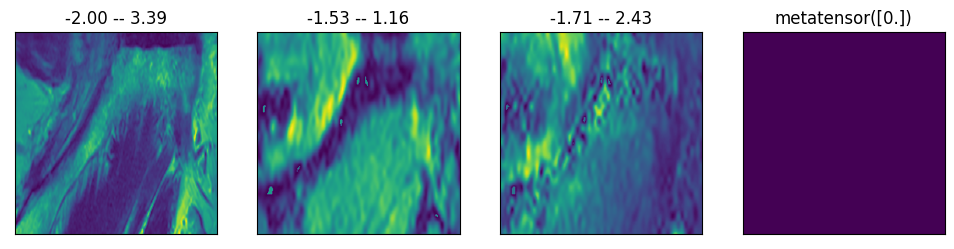

<Figure size 640x480 with 0 Axes>

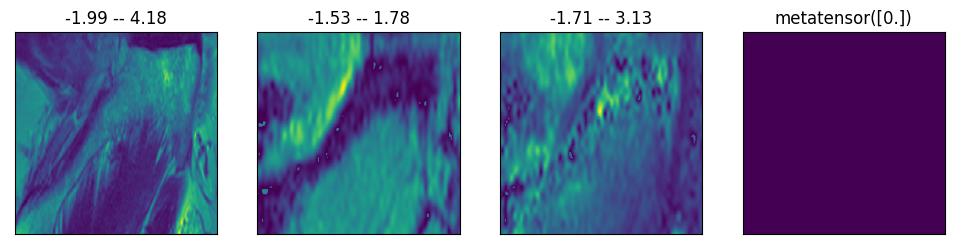

<Figure size 640x480 with 0 Axes>

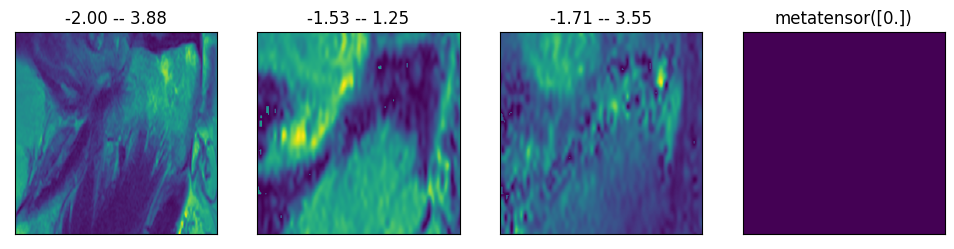

<Figure size 640x480 with 0 Axes>

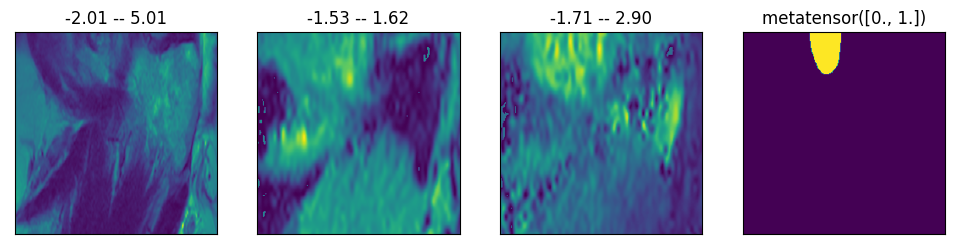

In [6]:
one_batch = train_ds[1]
print(one_batch['image'].shape)
print(one_batch['label'].shape)
for i in range(1,5):
    plt.figure()
    image = one_batch['image']
    label = one_batch['label']
    plt.figure(figsize=(12,6))
    plt.subplot(141), plt.imshow(image[0,:,:,i]), plt.title(f"{image[0,:,:,i].min():.2f} -- {image[0,:,:,i].max():.2f}"), plt.xticks([]), plt.yticks([])
    plt.subplot(142), plt.imshow(image[1,:,:,i]), plt.title(f"{image[1,:,:,i].min():.2f} -- {image[1,:,:,i].max():.2f}"), plt.xticks([]), plt.yticks([])
    plt.subplot(143), plt.imshow(image[2,:,:,i]), plt.title(f"{image[2,:,:,i].min():.2f} -- {image[2,:,:,i].max():.2f}"), plt.xticks([]), plt.yticks([])
    plt.subplot(144), plt.imshow(label[0,:,:,i]), plt.title(label[0,:,:,i].unique()), plt.xticks([]), plt.yticks([])

In [7]:
max_epochs = 300
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=3,
    out_channels=3,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=False, reduction="mean")
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 16),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [9]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_gland = []
metric_values_lesion = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in (pbar := tqdm(train_dl, total=len(train_dl))):
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        pbar.set_description(f"current loss {loss.item():.4f}")
        #print(
        #    f"{step}/{len(train_ds) // train_dl.batch_size}"
        #    f", train_loss: {loss.item():.4f}"
        #    f", step time: {(time.time() - step_start):.4f}"
        #)
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in valid_dl:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_gland = metric_batch[0].item()
            metric_values_gland.append(metric_gland)
            metric_lesion = metric_batch[1].item()
            metric_values_lesion.append(metric_lesion)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                #torch.save(
                #    model.state_dict(),
                #    os.path.join(root_dir, "best_metric_model.pth"),
                #)
                #print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" gland: {metric_gland:.4f} lesion: {metric_lesion:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/300


current loss 0.3639: 100%|██████████████████| 1400/1400 [20:58<00:00,  1.11it/s]


epoch 1 average loss: 0.4598
current epoch: 1 current mean dice: 0.2717 gland: 0.3057 lesion: 0.0160
best mean dice: 0.2717 at epoch: 1
time consuming of epoch 1 is: 1352.0142
----------
epoch 2/300


current loss 0.4252: 100%|██████████████████| 1400/1400 [19:14<00:00,  1.21it/s]


epoch 2 average loss: 0.4307
current epoch: 2 current mean dice: 0.1527 gland: 0.1710 lesion: 0.0024
best mean dice: 0.2717 at epoch: 1
time consuming of epoch 2 is: 1237.8521
----------
epoch 3/300


current loss 0.3611: 100%|██████████████████| 1400/1400 [19:07<00:00,  1.22it/s]


epoch 3 average loss: 0.4192
current epoch: 3 current mean dice: 0.1909 gland: 0.2106 lesion: 0.0138
best mean dice: 0.2717 at epoch: 1
time consuming of epoch 3 is: 1232.1040
----------
epoch 4/300


current loss 0.3743: 100%|██████████████████| 1400/1400 [19:09<00:00,  1.22it/s]


epoch 4 average loss: 0.4117
current epoch: 4 current mean dice: 0.1834 gland: 0.2026 lesion: 0.0172
best mean dice: 0.2717 at epoch: 1
time consuming of epoch 4 is: 1234.5709
----------
epoch 5/300


current loss 0.2164: 100%|██████████████████| 1400/1400 [19:11<00:00,  1.22it/s]


epoch 5 average loss: 0.4077
current epoch: 5 current mean dice: 0.1889 gland: 0.2164 lesion: 0.0102
best mean dice: 0.2717 at epoch: 1
time consuming of epoch 5 is: 1234.9530
----------
epoch 6/300


current loss 0.3966: 100%|██████████████████| 1400/1400 [19:07<00:00,  1.22it/s]


epoch 6 average loss: 0.4025
current epoch: 6 current mean dice: 0.1659 gland: 0.1863 lesion: 0.0067
best mean dice: 0.2717 at epoch: 1
time consuming of epoch 6 is: 1232.0642
----------
epoch 7/300


current loss 0.2076: 100%|██████████████████| 1400/1400 [19:08<00:00,  1.22it/s]


epoch 7 average loss: 0.3981
current epoch: 7 current mean dice: 0.1968 gland: 0.2182 lesion: 0.0110
best mean dice: 0.2717 at epoch: 1
time consuming of epoch 7 is: 1233.2858
----------
epoch 8/300


current loss 0.3658: 100%|██████████████████| 1400/1400 [19:10<00:00,  1.22it/s]


epoch 8 average loss: 0.3934
current epoch: 8 current mean dice: 0.2278 gland: 0.2524 lesion: 0.0245
best mean dice: 0.2717 at epoch: 1
time consuming of epoch 8 is: 1234.6194
----------
epoch 9/300


current loss 0.3666: 100%|██████████████████| 1400/1400 [19:12<00:00,  1.21it/s]


epoch 9 average loss: 0.3967
current epoch: 9 current mean dice: 0.2134 gland: 0.2331 lesion: 0.0085
best mean dice: 0.2717 at epoch: 1
time consuming of epoch 9 is: 1237.4195
----------
epoch 10/300


current loss 0.3483: 100%|██████████████████| 1400/1400 [19:12<00:00,  1.22it/s]


epoch 10 average loss: 0.3920
current epoch: 10 current mean dice: 0.2206 gland: 0.2426 lesion: 0.0145
best mean dice: 0.2717 at epoch: 1
time consuming of epoch 10 is: 1236.3863
----------
epoch 11/300


current loss 0.3566: 100%|██████████████████| 1400/1400 [19:18<00:00,  1.21it/s]


epoch 11 average loss: 0.3953
current epoch: 11 current mean dice: 0.2657 gland: 0.2977 lesion: 0.0126
best mean dice: 0.2717 at epoch: 1
time consuming of epoch 11 is: 1242.8500
----------
epoch 12/300


current loss 0.3611: 100%|██████████████████| 1400/1400 [19:13<00:00,  1.21it/s]


epoch 12 average loss: 0.3935
current epoch: 12 current mean dice: 0.3232 gland: 0.3692 lesion: 0.0071
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 12 is: 1238.9093
----------
epoch 13/300


current loss 0.3643: 100%|██████████████████| 1400/1400 [19:12<00:00,  1.21it/s]


epoch 13 average loss: 0.3892
current epoch: 13 current mean dice: 0.1623 gland: 0.1837 lesion: 0.0081
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 13 is: 1237.6767
----------
epoch 14/300


current loss 0.3623: 100%|██████████████████| 1400/1400 [19:10<00:00,  1.22it/s]


epoch 14 average loss: 0.3827
current epoch: 14 current mean dice: 0.1504 gland: 0.1690 lesion: 0.0030
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 14 is: 1235.7182
----------
epoch 15/300


current loss 0.3814: 100%|██████████████████| 1400/1400 [19:11<00:00,  1.22it/s]


epoch 15 average loss: 0.3861
current epoch: 15 current mean dice: 0.1653 gland: 0.1776 lesion: 0.0328
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 15 is: 1236.5631
----------
epoch 16/300


current loss 0.3633: 100%|██████████████████| 1400/1400 [19:10<00:00,  1.22it/s]


epoch 16 average loss: 0.3872
current epoch: 16 current mean dice: 0.1558 gland: 0.1772 lesion: 0.0075
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 16 is: 1235.2039
----------
epoch 17/300


current loss 0.3890: 100%|██████████████████| 1400/1400 [19:09<00:00,  1.22it/s]


epoch 17 average loss: 0.3786
current epoch: 17 current mean dice: 0.1793 gland: 0.1984 lesion: 0.0143
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 17 is: 1233.9962
----------
epoch 18/300


current loss 0.3693: 100%|██████████████████| 1400/1400 [19:15<00:00,  1.21it/s]


epoch 18 average loss: 0.3794
current epoch: 18 current mean dice: 0.1609 gland: 0.1763 lesion: 0.0209
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 18 is: 1239.1255
----------
epoch 19/300


current loss 0.3973: 100%|██████████████████| 1400/1400 [19:12<00:00,  1.21it/s]


epoch 19 average loss: 0.3821
current epoch: 19 current mean dice: 0.1568 gland: 0.1731 lesion: 0.0109
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 19 is: 1237.6126
----------
epoch 20/300


current loss 0.4063: 100%|██████████████████| 1400/1400 [19:12<00:00,  1.21it/s]


epoch 20 average loss: 0.3825
current epoch: 20 current mean dice: 0.1549 gland: 0.1745 lesion: 0.0313
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 20 is: 1237.1104
----------
epoch 21/300


current loss 0.3958: 100%|██████████████████| 1400/1400 [19:14<00:00,  1.21it/s]


epoch 21 average loss: 0.3778
current epoch: 21 current mean dice: 0.2266 gland: 0.2491 lesion: 0.0056
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 21 is: 1239.8634
----------
epoch 22/300


current loss 0.5316: 100%|██████████████████| 1400/1400 [19:12<00:00,  1.21it/s]


epoch 22 average loss: 0.3774
current epoch: 22 current mean dice: 0.1749 gland: 0.1973 lesion: 0.0095
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 22 is: 1237.9645
----------
epoch 23/300


current loss 0.3684: 100%|██████████████████| 1400/1400 [19:11<00:00,  1.22it/s]


epoch 23 average loss: 0.3815
current epoch: 23 current mean dice: 0.1618 gland: 0.1820 lesion: 0.0130
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 23 is: 1236.5497
----------
epoch 24/300


current loss 0.3637: 100%|██████████████████| 1400/1400 [19:11<00:00,  1.22it/s]


epoch 24 average loss: 0.3840
current epoch: 24 current mean dice: 0.2294 gland: 0.2590 lesion: 0.0042
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 24 is: 1235.6590
----------
epoch 25/300


current loss 0.4562: 100%|██████████████████| 1400/1400 [19:13<00:00,  1.21it/s]


epoch 25 average loss: 0.3764
current epoch: 25 current mean dice: 0.1330 gland: 0.1518 lesion: 0.0148
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 25 is: 1237.5972
----------
epoch 26/300


current loss 0.3538: 100%|██████████████████| 1400/1400 [19:15<00:00,  1.21it/s]


epoch 26 average loss: 0.3736
current epoch: 26 current mean dice: 0.1587 gland: 0.1773 lesion: 0.0062
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 26 is: 1239.8759
----------
epoch 27/300


current loss 0.3612: 100%|██████████████████| 1400/1400 [19:10<00:00,  1.22it/s]


epoch 27 average loss: 0.3754
current epoch: 27 current mean dice: 0.1329 gland: 0.1480 lesion: 0.0355
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 27 is: 1234.3199
----------
epoch 28/300


current loss 0.3547: 100%|██████████████████| 1400/1400 [19:08<00:00,  1.22it/s]


epoch 28 average loss: 0.3783
current epoch: 28 current mean dice: 0.1337 gland: 0.1448 lesion: 0.0034
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 28 is: 1233.4100
----------
epoch 29/300


current loss 0.4943: 100%|██████████████████| 1400/1400 [19:12<00:00,  1.21it/s]


epoch 29 average loss: 0.3776
current epoch: 29 current mean dice: 0.2349 gland: 0.2630 lesion: 0.0043
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 29 is: 1236.9030
----------
epoch 30/300


current loss 0.3849: 100%|██████████████████| 1400/1400 [19:09<00:00,  1.22it/s]


epoch 30 average loss: 0.3697
current epoch: 30 current mean dice: 0.1337 gland: 0.1528 lesion: 0.0099
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 30 is: 1233.7139
----------
epoch 31/300


current loss 0.3553: 100%|██████████████████| 1400/1400 [19:12<00:00,  1.21it/s]


epoch 31 average loss: 0.3797
current epoch: 31 current mean dice: 0.1460 gland: 0.1573 lesion: 0.0257
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 31 is: 1236.6465
----------
epoch 32/300


current loss 0.6672: 100%|██████████████████| 1400/1400 [19:09<00:00,  1.22it/s]


epoch 32 average loss: 0.3749
current epoch: 32 current mean dice: 0.1438 gland: 0.1651 lesion: 0.0037
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 32 is: 1234.4781
----------
epoch 33/300


current loss 0.2552: 100%|██████████████████| 1400/1400 [19:18<00:00,  1.21it/s]


epoch 33 average loss: 0.3719
current epoch: 33 current mean dice: 0.1540 gland: 0.1827 lesion: 0.0115
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 33 is: 1243.2754
----------
epoch 34/300


current loss 0.3708: 100%|██████████████████| 1400/1400 [19:14<00:00,  1.21it/s]


epoch 34 average loss: 0.3719
current epoch: 34 current mean dice: 0.2508 gland: 0.2859 lesion: 0.0144
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 34 is: 1239.4860
----------
epoch 35/300


current loss 0.1399: 100%|██████████████████| 1400/1400 [19:13<00:00,  1.21it/s]


epoch 35 average loss: 0.3714
current epoch: 35 current mean dice: 0.2477 gland: 0.2780 lesion: 0.0086
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 35 is: 1237.0969
----------
epoch 36/300


current loss 0.6456: 100%|██████████████████| 1400/1400 [19:13<00:00,  1.21it/s]


epoch 36 average loss: 0.3709
current epoch: 36 current mean dice: 0.2692 gland: 0.3038 lesion: 0.0068
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 36 is: 1239.4980
----------
epoch 37/300


current loss 0.3629: 100%|██████████████████| 1400/1400 [19:11<00:00,  1.22it/s]


epoch 37 average loss: 0.3728
current epoch: 37 current mean dice: 0.1308 gland: 0.1456 lesion: 0.0124
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 37 is: 1235.8818
----------
epoch 38/300


current loss 0.1796: 100%|██████████████████| 1400/1400 [19:10<00:00,  1.22it/s]


epoch 38 average loss: 0.3729
current epoch: 38 current mean dice: 0.1525 gland: 0.1747 lesion: 0.0334
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 38 is: 1234.9422
----------
epoch 39/300


current loss 0.3679: 100%|██████████████████| 1400/1400 [19:14<00:00,  1.21it/s]


epoch 39 average loss: 0.3717
current epoch: 39 current mean dice: 0.1260 gland: 0.1393 lesion: 0.0219
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 39 is: 1238.9846
----------
epoch 40/300


current loss 0.3821: 100%|██████████████████| 1400/1400 [19:13<00:00,  1.21it/s]


epoch 40 average loss: 0.3656
current epoch: 40 current mean dice: 0.1085 gland: 0.1257 lesion: 0.0099
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 40 is: 1238.6231
----------
epoch 41/300


current loss 0.3540: 100%|██████████████████| 1400/1400 [19:12<00:00,  1.21it/s]


epoch 41 average loss: 0.3726
current epoch: 41 current mean dice: 0.1402 gland: 0.1619 lesion: 0.0150
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 41 is: 1237.2752
----------
epoch 42/300


current loss 0.3554: 100%|██████████████████| 1400/1400 [19:10<00:00,  1.22it/s]


epoch 42 average loss: 0.3729
current epoch: 42 current mean dice: 0.1114 gland: 0.1255 lesion: 0.0118
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 42 is: 1235.5478
----------
epoch 43/300


current loss 0.0998: 100%|██████████████████| 1400/1400 [19:13<00:00,  1.21it/s]


epoch 43 average loss: 0.3732
current epoch: 43 current mean dice: 0.1145 gland: 0.1290 lesion: 0.0079
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 43 is: 1238.0609
----------
epoch 44/300


current loss 0.3661: 100%|██████████████████| 1400/1400 [19:14<00:00,  1.21it/s]


epoch 44 average loss: 0.3712
current epoch: 44 current mean dice: 0.2059 gland: 0.2283 lesion: 0.0164
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 44 is: 1239.8467
----------
epoch 45/300


current loss 0.6668: 100%|██████████████████| 1400/1400 [19:09<00:00,  1.22it/s]


epoch 45 average loss: 0.3635
current epoch: 45 current mean dice: 0.1444 gland: 0.1654 lesion: 0.0110
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 45 is: 1233.6253
----------
epoch 46/300


current loss 0.3583: 100%|██████████████████| 1400/1400 [19:16<00:00,  1.21it/s]


epoch 46 average loss: 0.3685
current epoch: 46 current mean dice: 0.1274 gland: 0.1466 lesion: 0.0099
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 46 is: 1241.4523
----------
epoch 47/300


current loss 0.6672: 100%|██████████████████| 1400/1400 [19:10<00:00,  1.22it/s]


epoch 47 average loss: 0.3703
current epoch: 47 current mean dice: 0.1606 gland: 0.1812 lesion: 0.0047
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 47 is: 1234.8280
----------
epoch 48/300


current loss 0.6673: 100%|██████████████████| 1400/1400 [19:15<00:00,  1.21it/s]


epoch 48 average loss: 0.3695
current epoch: 48 current mean dice: 0.1891 gland: 0.2127 lesion: 0.0207
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 48 is: 1240.5778
----------
epoch 49/300


current loss 0.3509: 100%|██████████████████| 1400/1400 [19:10<00:00,  1.22it/s]


epoch 49 average loss: 0.3640
current epoch: 49 current mean dice: 0.1679 gland: 0.1876 lesion: 0.0105
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 49 is: 1236.7663
----------
epoch 50/300


current loss 0.2384: 100%|██████████████████| 1400/1400 [19:15<00:00,  1.21it/s]


epoch 50 average loss: 0.3649
current epoch: 50 current mean dice: 0.1232 gland: 0.1365 lesion: 0.0049
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 50 is: 1239.6490
----------
epoch 51/300


current loss 0.1856: 100%|██████████████████| 1400/1400 [19:16<00:00,  1.21it/s]


epoch 51 average loss: 0.3693
current epoch: 51 current mean dice: 0.1771 gland: 0.2058 lesion: 0.0177
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 51 is: 1240.9857
----------
epoch 52/300


current loss 0.1338: 100%|██████████████████| 1400/1400 [19:12<00:00,  1.22it/s]


epoch 52 average loss: 0.3698
current epoch: 52 current mean dice: 0.1785 gland: 0.1952 lesion: 0.0144
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 52 is: 1237.1865
----------
epoch 53/300


current loss 0.3566: 100%|██████████████████| 1400/1400 [19:11<00:00,  1.22it/s]


epoch 53 average loss: 0.3624
current epoch: 53 current mean dice: 0.2050 gland: 0.2289 lesion: 0.0307
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 53 is: 1236.1611
----------
epoch 54/300


current loss 0.1341: 100%|██████████████████| 1400/1400 [19:17<00:00,  1.21it/s]


epoch 54 average loss: 0.3642
current epoch: 54 current mean dice: 0.1213 gland: 0.1381 lesion: 0.0064
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 54 is: 1243.0023
----------
epoch 55/300


current loss 0.6669: 100%|██████████████████| 1400/1400 [19:17<00:00,  1.21it/s]


epoch 55 average loss: 0.3659
current epoch: 55 current mean dice: 0.1984 gland: 0.2294 lesion: 0.0112
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 55 is: 1242.0900
----------
epoch 56/300


current loss 0.5089: 100%|██████████████████| 1400/1400 [19:11<00:00,  1.22it/s]


epoch 56 average loss: 0.3667
current epoch: 56 current mean dice: 0.1408 gland: 0.1567 lesion: 0.0155
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 56 is: 1236.1364
----------
epoch 57/300


current loss 0.3564: 100%|██████████████████| 1400/1400 [19:15<00:00,  1.21it/s]


epoch 57 average loss: 0.3632
current epoch: 57 current mean dice: 0.1924 gland: 0.2086 lesion: 0.0093
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 57 is: 1240.3952
----------
epoch 58/300


current loss 0.3931: 100%|██████████████████| 1400/1400 [19:11<00:00,  1.22it/s]


epoch 58 average loss: 0.3665
current epoch: 58 current mean dice: 0.1694 gland: 0.1975 lesion: 0.0097
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 58 is: 1235.8485
----------
epoch 59/300


current loss 0.1731: 100%|██████████████████| 1400/1400 [19:16<00:00,  1.21it/s]


epoch 59 average loss: 0.3625
current epoch: 59 current mean dice: 0.1681 gland: 0.1919 lesion: 0.0384
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 59 is: 1241.8361
----------
epoch 60/300


current loss 0.3699: 100%|██████████████████| 1400/1400 [19:11<00:00,  1.22it/s]


epoch 60 average loss: 0.3606
current epoch: 60 current mean dice: 0.2547 gland: 0.2915 lesion: 0.0266
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 60 is: 1234.9046
----------
epoch 61/300


current loss 0.3550: 100%|██████████████████| 1400/1400 [19:09<00:00,  1.22it/s]


epoch 61 average loss: 0.3645
current epoch: 61 current mean dice: 0.1214 gland: 0.1385 lesion: 0.0060
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 61 is: 1234.8178
----------
epoch 62/300


current loss 0.3666: 100%|██████████████████| 1400/1400 [19:13<00:00,  1.21it/s]


epoch 62 average loss: 0.3657
current epoch: 62 current mean dice: 0.1697 gland: 0.1919 lesion: 0.0324
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 62 is: 1238.0087
----------
epoch 63/300


current loss 0.3586: 100%|██████████████████| 1400/1400 [19:16<00:00,  1.21it/s]


epoch 63 average loss: 0.3625
current epoch: 63 current mean dice: 0.1670 gland: 0.1897 lesion: 0.0089
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 63 is: 1241.0393
----------
epoch 64/300


current loss 0.3657: 100%|██████████████████| 1400/1400 [19:12<00:00,  1.21it/s]


epoch 64 average loss: 0.3704
current epoch: 64 current mean dice: 0.2552 gland: 0.2975 lesion: 0.0230
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 64 is: 1237.1795
----------
epoch 65/300


current loss 0.3510: 100%|██████████████████| 1400/1400 [19:12<00:00,  1.21it/s]


epoch 65 average loss: 0.3619
current epoch: 65 current mean dice: 0.2811 gland: 0.3245 lesion: 0.0071
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 65 is: 1236.5004
----------
epoch 66/300


current loss 0.3607: 100%|██████████████████| 1400/1400 [19:11<00:00,  1.22it/s]


epoch 66 average loss: 0.3630
current epoch: 66 current mean dice: 0.1438 gland: 0.1630 lesion: 0.0050
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 66 is: 1236.2069
----------
epoch 67/300


current loss 0.2558: 100%|██████████████████| 1400/1400 [19:16<00:00,  1.21it/s]


epoch 67 average loss: 0.3672
current epoch: 67 current mean dice: 0.1633 gland: 0.1840 lesion: 0.0178
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 67 is: 1241.5059
----------
epoch 68/300


current loss 0.3589: 100%|██████████████████| 1400/1400 [19:11<00:00,  1.22it/s]


epoch 68 average loss: 0.3619
current epoch: 68 current mean dice: 0.1594 gland: 0.1762 lesion: 0.0338
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 68 is: 1236.0703
----------
epoch 69/300


current loss 0.6667: 100%|██████████████████| 1400/1400 [19:14<00:00,  1.21it/s]


epoch 69 average loss: 0.3655
current epoch: 69 current mean dice: 0.1149 gland: 0.1259 lesion: 0.0120
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 69 is: 1238.6749
----------
epoch 70/300


current loss 0.3622: 100%|██████████████████| 1400/1400 [19:14<00:00,  1.21it/s]


epoch 70 average loss: 0.3615
current epoch: 70 current mean dice: 0.1398 gland: 0.1603 lesion: 0.0229
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 70 is: 1239.5865
----------
epoch 71/300


current loss 0.3836: 100%|██████████████████| 1400/1400 [19:12<00:00,  1.22it/s]


epoch 71 average loss: 0.3624
current epoch: 71 current mean dice: 0.1672 gland: 0.1889 lesion: 0.0300
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 71 is: 1237.1287
----------
epoch 72/300


current loss 0.1450: 100%|██████████████████| 1400/1400 [19:15<00:00,  1.21it/s]


epoch 72 average loss: 0.3661
current epoch: 72 current mean dice: 0.1749 gland: 0.1958 lesion: 0.0263
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 72 is: 1240.9285
----------
epoch 73/300


current loss 0.3555: 100%|██████████████████| 1400/1400 [19:18<00:00,  1.21it/s]


epoch 73 average loss: 0.3578
current epoch: 73 current mean dice: 0.1316 gland: 0.1442 lesion: 0.0121
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 73 is: 1243.4467
----------
epoch 74/300


current loss 0.3464: 100%|██████████████████| 1400/1400 [19:15<00:00,  1.21it/s]


epoch 74 average loss: 0.3670
current epoch: 74 current mean dice: 0.1947 gland: 0.2270 lesion: 0.0066
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 74 is: 1239.9111
----------
epoch 75/300


current loss 0.3548: 100%|██████████████████| 1400/1400 [19:16<00:00,  1.21it/s]


epoch 75 average loss: 0.3661
current epoch: 75 current mean dice: 0.1316 gland: 0.1504 lesion: 0.0129
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 75 is: 1242.0099
----------
epoch 76/300


current loss 0.1708: 100%|██████████████████| 1400/1400 [19:12<00:00,  1.22it/s]


epoch 76 average loss: 0.3695
current epoch: 76 current mean dice: 0.1292 gland: 0.1428 lesion: 0.0125
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 76 is: 1236.0012
----------
epoch 77/300


current loss 0.3591: 100%|██████████████████| 1400/1400 [19:18<00:00,  1.21it/s]


epoch 77 average loss: 0.3614
current epoch: 77 current mean dice: 0.1569 gland: 0.1787 lesion: 0.0041
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 77 is: 1244.4134
----------
epoch 78/300


current loss 0.1440: 100%|██████████████████| 1400/1400 [19:15<00:00,  1.21it/s]


epoch 78 average loss: 0.3634
current epoch: 78 current mean dice: 0.1748 gland: 0.1971 lesion: 0.0035
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 78 is: 1240.0967
----------
epoch 79/300


current loss 0.6667: 100%|██████████████████| 1400/1400 [19:13<00:00,  1.21it/s]


epoch 79 average loss: 0.3604
current epoch: 79 current mean dice: 0.1360 gland: 0.1511 lesion: 0.0106
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 79 is: 1238.0595
----------
epoch 80/300


current loss 0.3526: 100%|██████████████████| 1400/1400 [19:18<00:00,  1.21it/s]


epoch 80 average loss: 0.3580
current epoch: 80 current mean dice: 0.1716 gland: 0.1967 lesion: 0.0079
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 80 is: 1243.6283
----------
epoch 81/300


current loss 0.6717: 100%|██████████████████| 1400/1400 [19:18<00:00,  1.21it/s]


epoch 81 average loss: 0.3654
current epoch: 81 current mean dice: 0.1032 gland: 0.1162 lesion: 0.0027
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 81 is: 1243.4332
----------
epoch 82/300


current loss 0.3549: 100%|██████████████████| 1400/1400 [19:16<00:00,  1.21it/s]


epoch 82 average loss: 0.3599
current epoch: 82 current mean dice: 0.1412 gland: 0.1602 lesion: 0.0047
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 82 is: 1241.5087
----------
epoch 83/300


current loss 0.3648: 100%|██████████████████| 1400/1400 [19:17<00:00,  1.21it/s]


epoch 83 average loss: 0.3664
current epoch: 83 current mean dice: 0.1847 gland: 0.2151 lesion: 0.0061
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 83 is: 1242.4264
----------
epoch 84/300


current loss 0.3532: 100%|██████████████████| 1400/1400 [19:20<00:00,  1.21it/s]


epoch 84 average loss: 0.3609
current epoch: 84 current mean dice: 0.2665 gland: 0.3132 lesion: 0.0044
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 84 is: 1245.6974
----------
epoch 85/300


current loss 0.3481: 100%|██████████████████| 1400/1400 [19:15<00:00,  1.21it/s]


epoch 85 average loss: 0.3598
current epoch: 85 current mean dice: 0.2115 gland: 0.2348 lesion: 0.0217
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 85 is: 1240.6480
----------
epoch 86/300


current loss 0.6667: 100%|██████████████████| 1400/1400 [19:20<00:00,  1.21it/s]


epoch 86 average loss: 0.3616
current epoch: 86 current mean dice: 0.1681 gland: 0.1885 lesion: 0.0174
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 86 is: 1245.0429
----------
epoch 87/300


current loss 0.3593: 100%|██████████████████| 1400/1400 [19:19<00:00,  1.21it/s]


epoch 87 average loss: 0.3616
current epoch: 87 current mean dice: 0.1787 gland: 0.2011 lesion: 0.0225
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 87 is: 1243.8490
----------
epoch 88/300


current loss 0.3586: 100%|██████████████████| 1400/1400 [19:13<00:00,  1.21it/s]


epoch 88 average loss: 0.3623
current epoch: 88 current mean dice: 0.1630 gland: 0.1823 lesion: 0.0132
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 88 is: 1238.4632
----------
epoch 89/300


current loss 0.3444: 100%|██████████████████| 1400/1400 [19:13<00:00,  1.21it/s]


epoch 89 average loss: 0.3628
current epoch: 89 current mean dice: 0.1374 gland: 0.1531 lesion: 0.0180
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 89 is: 1238.2655
----------
epoch 90/300


current loss 0.3692: 100%|██████████████████| 1400/1400 [19:13<00:00,  1.21it/s]


epoch 90 average loss: 0.3602
current epoch: 90 current mean dice: 0.1466 gland: 0.1659 lesion: 0.0150
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 90 is: 1238.1840
----------
epoch 91/300


current loss 0.3486: 100%|██████████████████| 1400/1400 [19:19<00:00,  1.21it/s]


epoch 91 average loss: 0.3620
current epoch: 91 current mean dice: 0.1305 gland: 0.1519 lesion: 0.0063
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 91 is: 1245.3657
----------
epoch 92/300


current loss 0.3634: 100%|██████████████████| 1400/1400 [19:16<00:00,  1.21it/s]


epoch 92 average loss: 0.3577
current epoch: 92 current mean dice: 0.1144 gland: 0.1314 lesion: 0.0059
best mean dice: 0.3232 at epoch: 12
time consuming of epoch 92 is: 1242.1806
----------
epoch 93/300


current loss 0.0642: 100%|██████████████████| 1400/1400 [19:19<00:00,  1.21it/s]


epoch 93 average loss: 0.3617
current epoch: 93 current mean dice: 0.4977 gland: 0.5596 lesion: 0.0076
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 93 is: 1242.5573
----------
epoch 94/300


current loss 0.3606: 100%|██████████████████| 1400/1400 [19:16<00:00,  1.21it/s]


epoch 94 average loss: 0.3635
current epoch: 94 current mean dice: 0.1527 gland: 0.1794 lesion: 0.0045
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 94 is: 1241.7736
----------
epoch 95/300


current loss 0.3563: 100%|██████████████████| 1400/1400 [19:21<00:00,  1.21it/s]


epoch 95 average loss: 0.3607
current epoch: 95 current mean dice: 0.1744 gland: 0.1990 lesion: 0.0084
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 95 is: 1245.9643
----------
epoch 96/300


current loss 0.3919: 100%|██████████████████| 1400/1400 [19:16<00:00,  1.21it/s]


epoch 96 average loss: 0.3589
current epoch: 96 current mean dice: 0.1362 gland: 0.1512 lesion: 0.0047
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 96 is: 1240.8932
----------
epoch 97/300


current loss 0.6667: 100%|██████████████████| 1400/1400 [19:15<00:00,  1.21it/s]


epoch 97 average loss: 0.3664
current epoch: 97 current mean dice: 0.1272 gland: 0.1472 lesion: 0.0329
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 97 is: 1239.9225
----------
epoch 98/300


current loss 0.3467: 100%|██████████████████| 1400/1400 [19:19<00:00,  1.21it/s]


epoch 98 average loss: 0.3593
current epoch: 98 current mean dice: 0.1137 gland: 0.1264 lesion: 0.0154
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 98 is: 1244.2989
----------
epoch 99/300


current loss 0.1802: 100%|██████████████████| 1400/1400 [19:20<00:00,  1.21it/s]


epoch 99 average loss: 0.3585
current epoch: 99 current mean dice: 0.2117 gland: 0.2343 lesion: 0.0243
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 99 is: 1245.5180
----------
epoch 100/300


current loss 0.5762: 100%|██████████████████| 1400/1400 [19:20<00:00,  1.21it/s]


epoch 100 average loss: 0.3617
current epoch: 100 current mean dice: 0.1649 gland: 0.1779 lesion: 0.0274
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 100 is: 1245.8036
----------
epoch 101/300


current loss 0.3584: 100%|██████████████████| 1400/1400 [19:21<00:00,  1.21it/s]


epoch 101 average loss: 0.3626
current epoch: 101 current mean dice: 0.1583 gland: 0.1809 lesion: 0.0036
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 101 is: 1245.4751
----------
epoch 102/300


current loss 0.3629: 100%|██████████████████| 1400/1400 [19:21<00:00,  1.21it/s]


epoch 102 average loss: 0.3639
current epoch: 102 current mean dice: 0.1175 gland: 0.1311 lesion: 0.0182
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 102 is: 1245.9071
----------
epoch 103/300


current loss 0.1779: 100%|██████████████████| 1400/1400 [19:17<00:00,  1.21it/s]


epoch 103 average loss: 0.3580
current epoch: 103 current mean dice: 0.1284 gland: 0.1440 lesion: 0.0193
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 103 is: 1242.6604
----------
epoch 104/300


current loss 0.3799: 100%|██████████████████| 1400/1400 [19:17<00:00,  1.21it/s]


epoch 104 average loss: 0.3603
current epoch: 104 current mean dice: 0.1536 gland: 0.1730 lesion: 0.0043
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 104 is: 1243.5700
----------
epoch 105/300


current loss 0.3738: 100%|██████████████████| 1400/1400 [19:18<00:00,  1.21it/s]


epoch 105 average loss: 0.3602
current epoch: 105 current mean dice: 0.1749 gland: 0.1903 lesion: 0.0044
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 105 is: 1241.9025
----------
epoch 106/300


current loss 0.3567: 100%|██████████████████| 1400/1400 [19:21<00:00,  1.21it/s]


epoch 106 average loss: 0.3567
current epoch: 106 current mean dice: 0.1796 gland: 0.2070 lesion: 0.0151
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 106 is: 1246.2737
----------
epoch 107/300


current loss 0.3558: 100%|██████████████████| 1400/1400 [19:20<00:00,  1.21it/s]


epoch 107 average loss: 0.3628
current epoch: 107 current mean dice: 0.1508 gland: 0.1745 lesion: 0.0207
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 107 is: 1245.1958
----------
epoch 108/300


current loss 0.3584: 100%|██████████████████| 1400/1400 [19:23<00:00,  1.20it/s]


epoch 108 average loss: 0.3569
current epoch: 108 current mean dice: 0.1420 gland: 0.1582 lesion: 0.0036
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 108 is: 1248.3006
----------
epoch 109/300


current loss 0.1063: 100%|██████████████████| 1400/1400 [19:20<00:00,  1.21it/s]


epoch 109 average loss: 0.3626
current epoch: 109 current mean dice: 0.1443 gland: 0.1646 lesion: 0.0033
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 109 is: 1245.6294
----------
epoch 110/300


current loss 0.3671: 100%|██████████████████| 1400/1400 [19:21<00:00,  1.20it/s]


epoch 110 average loss: 0.3585
current epoch: 110 current mean dice: 0.1259 gland: 0.1445 lesion: 0.0059
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 110 is: 1246.5662
----------
epoch 111/300


current loss 0.3477: 100%|██████████████████| 1400/1400 [19:24<00:00,  1.20it/s]


epoch 111 average loss: 0.3613
current epoch: 111 current mean dice: 0.1763 gland: 0.2024 lesion: 0.0106
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 111 is: 1249.0702
----------
epoch 112/300


current loss 0.3570: 100%|██████████████████| 1400/1400 [19:23<00:00,  1.20it/s]


epoch 112 average loss: 0.3541
current epoch: 112 current mean dice: 0.1603 gland: 0.1778 lesion: 0.0234
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 112 is: 1247.3539
----------
epoch 113/300


current loss 0.3514: 100%|██████████████████| 1400/1400 [19:21<00:00,  1.21it/s]


epoch 113 average loss: 0.3580
current epoch: 113 current mean dice: 0.2769 gland: 0.3230 lesion: 0.0175
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 113 is: 1246.9279
----------
epoch 114/300


current loss 0.3467: 100%|██████████████████| 1400/1400 [19:20<00:00,  1.21it/s]


epoch 114 average loss: 0.3559
current epoch: 114 current mean dice: 0.1500 gland: 0.1694 lesion: 0.0038
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 114 is: 1245.2842
----------
epoch 115/300


current loss 0.3491: 100%|██████████████████| 1400/1400 [19:18<00:00,  1.21it/s]


epoch 115 average loss: 0.3603
current epoch: 115 current mean dice: 0.1564 gland: 0.1799 lesion: 0.0041
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 115 is: 1244.0100
----------
epoch 116/300


current loss 0.5558: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 116 average loss: 0.3567
current epoch: 116 current mean dice: 0.1697 gland: 0.1882 lesion: 0.0062
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 116 is: 1253.1963
----------
epoch 117/300


current loss 0.2734: 100%|██████████████████| 1400/1400 [19:21<00:00,  1.20it/s]


epoch 117 average loss: 0.3638
current epoch: 117 current mean dice: 0.1314 gland: 0.1500 lesion: 0.0074
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 117 is: 1246.1580
----------
epoch 118/300


current loss 0.0736: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 118 average loss: 0.3560
current epoch: 118 current mean dice: 0.2140 gland: 0.2473 lesion: 0.0198
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 118 is: 1253.0790
----------
epoch 119/300


current loss 0.1862: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 119 average loss: 0.3519
current epoch: 119 current mean dice: 0.1588 gland: 0.1761 lesion: 0.0063
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 119 is: 1252.5843
----------
epoch 120/300


current loss 0.6667: 100%|██████████████████| 1400/1400 [19:24<00:00,  1.20it/s]


epoch 120 average loss: 0.3541
current epoch: 120 current mean dice: 0.1638 gland: 0.1925 lesion: 0.0067
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 120 is: 1248.2919
----------
epoch 121/300


current loss 0.5944: 100%|██████████████████| 1400/1400 [19:26<00:00,  1.20it/s]


epoch 121 average loss: 0.3617
current epoch: 121 current mean dice: 0.1344 gland: 0.1562 lesion: 0.0242
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 121 is: 1251.1341
----------
epoch 122/300


current loss 0.5361: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 122 average loss: 0.3606
current epoch: 122 current mean dice: 0.1666 gland: 0.1852 lesion: 0.0072
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 122 is: 1252.9787
----------
epoch 123/300


current loss 0.3473: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 123 average loss: 0.3575
current epoch: 123 current mean dice: 0.1889 gland: 0.2117 lesion: 0.0141
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 123 is: 1253.8043
----------
epoch 124/300


current loss 0.1616: 100%|██████████████████| 1400/1400 [19:19<00:00,  1.21it/s]


epoch 124 average loss: 0.3570
current epoch: 124 current mean dice: 0.1319 gland: 0.1463 lesion: 0.0230
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 124 is: 1244.5923
----------
epoch 125/300


current loss 0.3542: 100%|██████████████████| 1400/1400 [19:25<00:00,  1.20it/s]


epoch 125 average loss: 0.3615
current epoch: 125 current mean dice: 0.1775 gland: 0.1938 lesion: 0.0546
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 125 is: 1249.8546
----------
epoch 126/300


current loss 0.1285: 100%|██████████████████| 1400/1400 [19:26<00:00,  1.20it/s]


epoch 126 average loss: 0.3553
current epoch: 126 current mean dice: 0.1555 gland: 0.1689 lesion: 0.0448
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 126 is: 1251.4023
----------
epoch 127/300


current loss 0.3740: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 127 average loss: 0.3587
current epoch: 127 current mean dice: 0.1786 gland: 0.2054 lesion: 0.0039
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 127 is: 1252.6102
----------
epoch 128/300


current loss 0.3952: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 128 average loss: 0.3511
current epoch: 128 current mean dice: 0.1809 gland: 0.1989 lesion: 0.0074
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 128 is: 1252.6989
----------
epoch 129/300


current loss 0.2375: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 129 average loss: 0.3540
current epoch: 129 current mean dice: 0.1527 gland: 0.1746 lesion: 0.0091
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 129 is: 1251.9554
----------
epoch 130/300


current loss 0.3619: 100%|██████████████████| 1400/1400 [19:24<00:00,  1.20it/s]


epoch 130 average loss: 0.3559
current epoch: 130 current mean dice: 0.1470 gland: 0.1640 lesion: 0.0031
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 130 is: 1248.6027
----------
epoch 131/300


current loss 0.0925: 100%|██████████████████| 1400/1400 [19:26<00:00,  1.20it/s]


epoch 131 average loss: 0.3558
current epoch: 131 current mean dice: 0.1396 gland: 0.1591 lesion: 0.0142
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 131 is: 1251.8084
----------
epoch 132/300


current loss 0.3550: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 132 average loss: 0.3566
current epoch: 132 current mean dice: 0.1468 gland: 0.1688 lesion: 0.0126
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 132 is: 1253.4095
----------
epoch 133/300


current loss 0.3512: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 133 average loss: 0.3538
current epoch: 133 current mean dice: 0.3233 gland: 0.3674 lesion: 0.0088
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 133 is: 1251.8341
----------
epoch 134/300


current loss 0.3672: 100%|██████████████████| 1400/1400 [19:25<00:00,  1.20it/s]


epoch 134 average loss: 0.3575
current epoch: 134 current mean dice: 0.1589 gland: 0.1904 lesion: 0.0039
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 134 is: 1250.4195
----------
epoch 135/300


current loss 0.1076: 100%|██████████████████| 1400/1400 [19:25<00:00,  1.20it/s]


epoch 135 average loss: 0.3518
current epoch: 135 current mean dice: 0.2225 gland: 0.2551 lesion: 0.0117
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 135 is: 1249.1044
----------
epoch 136/300


current loss 0.3539: 100%|██████████████████| 1400/1400 [19:23<00:00,  1.20it/s]


epoch 136 average loss: 0.3545
current epoch: 136 current mean dice: 0.1844 gland: 0.2044 lesion: 0.0173
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 136 is: 1248.5949
----------
epoch 137/300


current loss 0.0928: 100%|██████████████████| 1400/1400 [19:26<00:00,  1.20it/s]


epoch 137 average loss: 0.3535
current epoch: 137 current mean dice: 0.1606 gland: 0.1762 lesion: 0.0312
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 137 is: 1251.1120
----------
epoch 138/300


current loss 0.3544: 100%|██████████████████| 1400/1400 [19:24<00:00,  1.20it/s]


epoch 138 average loss: 0.3538
current epoch: 138 current mean dice: 0.1855 gland: 0.2084 lesion: 0.0077
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 138 is: 1249.7903
----------
epoch 139/300


current loss 0.6667: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 139 average loss: 0.3556
current epoch: 139 current mean dice: 0.1516 gland: 0.1712 lesion: 0.0062
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 139 is: 1253.8510
----------
epoch 140/300


current loss 0.3912: 100%|██████████████████| 1400/1400 [19:24<00:00,  1.20it/s]


epoch 140 average loss: 0.3583
current epoch: 140 current mean dice: 0.1340 gland: 0.1543 lesion: 0.0072
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 140 is: 1249.9683
----------
epoch 141/300


current loss 0.6667: 100%|██████████████████| 1400/1400 [19:31<00:00,  1.20it/s]


epoch 141 average loss: 0.3593
current epoch: 141 current mean dice: 0.1954 gland: 0.2221 lesion: 0.0061
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 141 is: 1256.1193
----------
epoch 142/300


current loss 0.3520: 100%|██████████████████| 1400/1400 [19:24<00:00,  1.20it/s]


epoch 142 average loss: 0.3524
current epoch: 142 current mean dice: 0.2297 gland: 0.2655 lesion: 0.0076
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 142 is: 1249.9301
----------
epoch 143/300


current loss 0.2626: 100%|██████████████████| 1400/1400 [19:30<00:00,  1.20it/s]


epoch 143 average loss: 0.3542
current epoch: 143 current mean dice: 0.1566 gland: 0.1776 lesion: 0.0063
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 143 is: 1254.9609
----------
epoch 144/300


current loss 0.1077: 100%|██████████████████| 1400/1400 [19:30<00:00,  1.20it/s]


epoch 144 average loss: 0.3585
current epoch: 144 current mean dice: 0.1571 gland: 0.1820 lesion: 0.0073
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 144 is: 1255.8829
----------
epoch 145/300


current loss 0.3813: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 145 average loss: 0.3548
current epoch: 145 current mean dice: 0.2536 gland: 0.2830 lesion: 0.0042
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 145 is: 1253.1365
----------
epoch 146/300


current loss 0.3524: 100%|██████████████████| 1400/1400 [19:24<00:00,  1.20it/s]


epoch 146 average loss: 0.3570
current epoch: 146 current mean dice: 0.1798 gland: 0.2062 lesion: 0.0113
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 146 is: 1249.9186
----------
epoch 147/300


current loss 0.3443: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 147 average loss: 0.3526
current epoch: 147 current mean dice: 0.1091 gland: 0.1242 lesion: 0.0212
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 147 is: 1252.9309
----------
epoch 148/300


current loss 0.3556: 100%|██████████████████| 1400/1400 [19:33<00:00,  1.19it/s]


epoch 148 average loss: 0.3550
current epoch: 148 current mean dice: 0.1310 gland: 0.1486 lesion: 0.0053
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 148 is: 1258.7174
----------
epoch 149/300


current loss 0.3544: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 149 average loss: 0.3565
current epoch: 149 current mean dice: 0.2035 gland: 0.2391 lesion: 0.0078
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 149 is: 1253.8030
----------
epoch 150/300


current loss 0.3514: 100%|██████████████████| 1400/1400 [19:25<00:00,  1.20it/s]


epoch 150 average loss: 0.3513
current epoch: 150 current mean dice: 0.1603 gland: 0.1859 lesion: 0.0068
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 150 is: 1250.6434
----------
epoch 151/300


current loss 0.3480: 100%|██████████████████| 1400/1400 [19:25<00:00,  1.20it/s]


epoch 151 average loss: 0.3560
current epoch: 151 current mean dice: 0.1538 gland: 0.1820 lesion: 0.0056
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 151 is: 1250.2809
----------
epoch 152/300


current loss 0.3505: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 152 average loss: 0.3555
current epoch: 152 current mean dice: 0.2504 gland: 0.2928 lesion: 0.0042
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 152 is: 1251.2789
----------
epoch 153/300


current loss 0.3529: 100%|██████████████████| 1400/1400 [19:26<00:00,  1.20it/s]


epoch 153 average loss: 0.3535
current epoch: 153 current mean dice: 0.1454 gland: 0.1577 lesion: 0.0109
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 153 is: 1251.5711
----------
epoch 154/300


current loss 0.3459: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 154 average loss: 0.3530
current epoch: 154 current mean dice: 0.1895 gland: 0.2204 lesion: 0.0138
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 154 is: 1251.8847
----------
epoch 155/300


current loss 0.2157: 100%|██████████████████| 1400/1400 [19:26<00:00,  1.20it/s]


epoch 155 average loss: 0.3554
current epoch: 155 current mean dice: 0.1962 gland: 0.2312 lesion: 0.0062
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 155 is: 1250.9666
----------
epoch 156/300


current loss 0.3578: 100%|██████████████████| 1400/1400 [19:25<00:00,  1.20it/s]


epoch 156 average loss: 0.3574
current epoch: 156 current mean dice: 0.1689 gland: 0.1945 lesion: 0.0071
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 156 is: 1249.7597
----------
epoch 157/300


current loss 0.3557: 100%|██████████████████| 1400/1400 [19:24<00:00,  1.20it/s]


epoch 157 average loss: 0.3548
current epoch: 157 current mean dice: 0.1841 gland: 0.2153 lesion: 0.0140
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 157 is: 1249.9833
----------
epoch 158/300


current loss 0.3474: 100%|██████████████████| 1400/1400 [19:23<00:00,  1.20it/s]


epoch 158 average loss: 0.3490
current epoch: 158 current mean dice: 0.2065 gland: 0.2331 lesion: 0.0200
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 158 is: 1248.8514
----------
epoch 159/300


current loss 0.3552: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 159 average loss: 0.3570
current epoch: 159 current mean dice: 0.1591 gland: 0.1784 lesion: 0.0160
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 159 is: 1251.8986
----------
epoch 160/300


current loss 0.3460: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 160 average loss: 0.3576
current epoch: 160 current mean dice: 0.2148 gland: 0.2451 lesion: 0.0213
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 160 is: 1252.6764
----------
epoch 161/300


current loss 0.1083: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 161 average loss: 0.3517
current epoch: 161 current mean dice: 0.2203 gland: 0.2580 lesion: 0.0051
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 161 is: 1253.4791
----------
epoch 162/300


current loss 0.6667: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 162 average loss: 0.3558
current epoch: 162 current mean dice: 0.1865 gland: 0.2115 lesion: 0.0068
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 162 is: 1252.1886
----------
epoch 163/300


current loss 0.3523: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 163 average loss: 0.3579
current epoch: 163 current mean dice: 0.1655 gland: 0.1941 lesion: 0.0108
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 163 is: 1254.3287
----------
epoch 164/300


current loss 0.3509: 100%|██████████████████| 1400/1400 [19:26<00:00,  1.20it/s]


epoch 164 average loss: 0.3513
current epoch: 164 current mean dice: 0.2108 gland: 0.2471 lesion: 0.0240
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 164 is: 1252.3512
----------
epoch 165/300


current loss 0.1751: 100%|██████████████████| 1400/1400 [19:32<00:00,  1.19it/s]


epoch 165 average loss: 0.3530
current epoch: 165 current mean dice: 0.1720 gland: 0.2047 lesion: 0.0056
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 165 is: 1256.9444
----------
epoch 166/300


current loss 0.3561: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 166 average loss: 0.3565
current epoch: 166 current mean dice: 0.1882 gland: 0.2127 lesion: 0.0107
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 166 is: 1252.8996
----------
epoch 167/300


current loss 0.3498: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 167 average loss: 0.3511
current epoch: 167 current mean dice: 0.2028 gland: 0.2371 lesion: 0.0063
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 167 is: 1254.1342
----------
epoch 168/300


current loss 0.0967: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 168 average loss: 0.3524
current epoch: 168 current mean dice: 0.2912 gland: 0.3346 lesion: 0.0044
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 168 is: 1252.6118
----------
epoch 169/300


current loss 0.3358: 100%|██████████████████| 1400/1400 [19:22<00:00,  1.20it/s]


epoch 169 average loss: 0.3530
current epoch: 169 current mean dice: 0.2511 gland: 0.2839 lesion: 0.0110
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 169 is: 1248.1496
----------
epoch 170/300


current loss 0.3454: 100%|██████████████████| 1400/1400 [19:25<00:00,  1.20it/s]


epoch 170 average loss: 0.3551
current epoch: 170 current mean dice: 0.1753 gland: 0.1949 lesion: 0.0261
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 170 is: 1249.6357
----------
epoch 171/300


current loss 0.3471: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 171 average loss: 0.3450
current epoch: 171 current mean dice: 0.1259 gland: 0.1480 lesion: 0.0058
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 171 is: 1252.9655
----------
epoch 172/300


current loss 0.3695: 100%|██████████████████| 1400/1400 [19:21<00:00,  1.20it/s]


epoch 172 average loss: 0.3576
current epoch: 172 current mean dice: 0.1579 gland: 0.1832 lesion: 0.0116
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 172 is: 1246.6086
----------
epoch 173/300


current loss 0.3473: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 173 average loss: 0.3496
current epoch: 173 current mean dice: 0.1373 gland: 0.1567 lesion: 0.0242
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 173 is: 1254.9358
----------
epoch 174/300


current loss 0.3474: 100%|██████████████████| 1400/1400 [19:30<00:00,  1.20it/s]


epoch 174 average loss: 0.3489
current epoch: 174 current mean dice: 0.1817 gland: 0.2088 lesion: 0.0113
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 174 is: 1254.8493
----------
epoch 175/300


current loss 0.3548: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 175 average loss: 0.3565
current epoch: 175 current mean dice: 0.1951 gland: 0.2303 lesion: 0.0141
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 175 is: 1253.1428
----------
epoch 176/300


current loss 0.3737: 100%|██████████████████| 1400/1400 [19:23<00:00,  1.20it/s]


epoch 176 average loss: 0.3498
current epoch: 176 current mean dice: 0.1618 gland: 0.1836 lesion: 0.0276
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 176 is: 1248.3278
----------
epoch 177/300


current loss 0.3499: 100%|██████████████████| 1400/1400 [19:25<00:00,  1.20it/s]


epoch 177 average loss: 0.3523
current epoch: 177 current mean dice: 0.1516 gland: 0.1739 lesion: 0.0066
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 177 is: 1248.9195
----------
epoch 178/300


current loss 0.2772: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 178 average loss: 0.3576
current epoch: 178 current mean dice: 0.1278 gland: 0.1404 lesion: 0.0031
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 178 is: 1253.2161
----------
epoch 179/300


current loss 0.1977: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 179 average loss: 0.3519
current epoch: 179 current mean dice: 0.1778 gland: 0.2061 lesion: 0.0069
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 179 is: 1252.8508
----------
epoch 180/300


current loss 0.3507: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 180 average loss: 0.3556
current epoch: 180 current mean dice: 0.1450 gland: 0.1674 lesion: 0.0062
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 180 is: 1253.7039
----------
epoch 181/300


current loss 0.3631: 100%|██████████████████| 1400/1400 [19:31<00:00,  1.20it/s]


epoch 181 average loss: 0.3523
current epoch: 181 current mean dice: 0.1375 gland: 0.1575 lesion: 0.0081
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 181 is: 1255.8540
----------
epoch 182/300


current loss 0.3410: 100%|██████████████████| 1400/1400 [19:31<00:00,  1.19it/s]


epoch 182 average loss: 0.3539
current epoch: 182 current mean dice: 0.1434 gland: 0.1646 lesion: 0.0070
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 182 is: 1256.9196
----------
epoch 183/300


current loss 0.3548: 100%|██████████████████| 1400/1400 [19:26<00:00,  1.20it/s]


epoch 183 average loss: 0.3522
current epoch: 183 current mean dice: 0.1818 gland: 0.2066 lesion: 0.0036
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 183 is: 1251.2065
----------
epoch 184/300


current loss 0.0748: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 184 average loss: 0.3531
current epoch: 184 current mean dice: 0.1552 gland: 0.1785 lesion: 0.0225
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 184 is: 1253.2570
----------
epoch 185/300


current loss 0.3473: 100%|██████████████████| 1400/1400 [19:26<00:00,  1.20it/s]


epoch 185 average loss: 0.3490
current epoch: 185 current mean dice: 0.1857 gland: 0.2151 lesion: 0.0102
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 185 is: 1250.6971
----------
epoch 186/300


current loss 0.3701: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 186 average loss: 0.3469
current epoch: 186 current mean dice: 0.1798 gland: 0.2094 lesion: 0.0257
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 186 is: 1253.0024
----------
epoch 187/300


current loss 0.3769: 100%|██████████████████| 1400/1400 [19:26<00:00,  1.20it/s]


epoch 187 average loss: 0.3467
current epoch: 187 current mean dice: 0.1547 gland: 0.1796 lesion: 0.0087
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 187 is: 1251.1789
----------
epoch 188/300


current loss 0.3537: 100%|██████████████████| 1400/1400 [19:24<00:00,  1.20it/s]


epoch 188 average loss: 0.3529
current epoch: 188 current mean dice: 0.1316 gland: 0.1511 lesion: 0.0121
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 188 is: 1248.9189
----------
epoch 189/300


current loss 0.4938: 100%|██████████████████| 1400/1400 [19:25<00:00,  1.20it/s]


epoch 189 average loss: 0.3496
current epoch: 189 current mean dice: 0.1341 gland: 0.1553 lesion: 0.0225
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 189 is: 1250.3170
----------
epoch 190/300


current loss 0.3510: 100%|██████████████████| 1400/1400 [19:25<00:00,  1.20it/s]


epoch 190 average loss: 0.3509
current epoch: 190 current mean dice: 0.1749 gland: 0.2030 lesion: 0.0045
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 190 is: 1249.6642
----------
epoch 191/300


current loss 0.3637: 100%|██████████████████| 1400/1400 [19:24<00:00,  1.20it/s]


epoch 191 average loss: 0.3552
current epoch: 191 current mean dice: 0.1709 gland: 0.1970 lesion: 0.0205
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 191 is: 1248.0758
----------
epoch 192/300


current loss 0.3449: 100%|██████████████████| 1400/1400 [19:31<00:00,  1.20it/s]


epoch 192 average loss: 0.3494
current epoch: 192 current mean dice: 0.1617 gland: 0.1856 lesion: 0.0139
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 192 is: 1255.0454
----------
epoch 193/300


current loss 0.0811: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 193 average loss: 0.3538
current epoch: 193 current mean dice: 0.1601 gland: 0.1825 lesion: 0.0037
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 193 is: 1252.2186
----------
epoch 194/300


current loss 0.6307: 100%|██████████████████| 1400/1400 [19:25<00:00,  1.20it/s]


epoch 194 average loss: 0.3518
current epoch: 194 current mean dice: 0.1717 gland: 0.2089 lesion: 0.0068
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 194 is: 1249.8075
----------
epoch 195/300


current loss 0.1120: 100%|██████████████████| 1400/1400 [19:23<00:00,  1.20it/s]


epoch 195 average loss: 0.3505
current epoch: 195 current mean dice: 0.4119 gland: 0.4759 lesion: 0.0136
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 195 is: 1248.3803
----------
epoch 196/300


current loss 0.1208: 100%|██████████████████| 1400/1400 [19:25<00:00,  1.20it/s]


epoch 196 average loss: 0.3476
current epoch: 196 current mean dice: 0.1329 gland: 0.1498 lesion: 0.0127
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 196 is: 1248.9043
----------
epoch 197/300


current loss 0.4782: 100%|██████████████████| 1400/1400 [19:32<00:00,  1.19it/s]


epoch 197 average loss: 0.3451
current epoch: 197 current mean dice: 0.2116 gland: 0.2406 lesion: 0.0091
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 197 is: 1257.0487
----------
epoch 198/300


current loss 0.3647: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 198 average loss: 0.3477
current epoch: 198 current mean dice: 0.1450 gland: 0.1658 lesion: 0.0051
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 198 is: 1253.3032
----------
epoch 199/300


current loss 0.1191: 100%|██████████████████| 1400/1400 [19:25<00:00,  1.20it/s]


epoch 199 average loss: 0.3492
current epoch: 199 current mean dice: 0.1328 gland: 0.1518 lesion: 0.0217
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 199 is: 1250.7801
----------
epoch 200/300


current loss 0.5868: 100%|██████████████████| 1400/1400 [19:26<00:00,  1.20it/s]


epoch 200 average loss: 0.3490
current epoch: 200 current mean dice: 0.1861 gland: 0.2111 lesion: 0.0101
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 200 is: 1251.2319
----------
epoch 201/300


current loss 0.6667: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 201 average loss: 0.3544
current epoch: 201 current mean dice: 0.1366 gland: 0.1560 lesion: 0.0148
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 201 is: 1254.9579
----------
epoch 202/300


current loss 0.3452: 100%|██████████████████| 1400/1400 [19:22<00:00,  1.20it/s]


epoch 202 average loss: 0.3483
current epoch: 202 current mean dice: 0.1136 gland: 0.1282 lesion: 0.0118
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 202 is: 1247.1120
----------
epoch 203/300


current loss 0.3953: 100%|██████████████████| 1400/1400 [19:24<00:00,  1.20it/s]


epoch 203 average loss: 0.3460
current epoch: 203 current mean dice: 0.1569 gland: 0.1692 lesion: 0.0047
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 203 is: 1249.1631
----------
epoch 204/300


current loss 0.3487: 100%|██████████████████| 1400/1400 [19:26<00:00,  1.20it/s]


epoch 204 average loss: 0.3554
current epoch: 204 current mean dice: 0.1753 gland: 0.1987 lesion: 0.0210
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 204 is: 1250.6457
----------
epoch 205/300


current loss 0.1599: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 205 average loss: 0.3527
current epoch: 205 current mean dice: 0.1890 gland: 0.2141 lesion: 0.0050
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 205 is: 1253.7556
----------
epoch 206/300


current loss 0.3503: 100%|██████████████████| 1400/1400 [19:30<00:00,  1.20it/s]


epoch 206 average loss: 0.3542
current epoch: 206 current mean dice: 0.1311 gland: 0.1428 lesion: 0.0060
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 206 is: 1254.9953
----------
epoch 207/300


current loss 0.3450: 100%|██████████████████| 1400/1400 [19:30<00:00,  1.20it/s]


epoch 207 average loss: 0.3481
current epoch: 207 current mean dice: 0.1456 gland: 0.1683 lesion: 0.0180
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 207 is: 1255.5267
----------
epoch 208/300


current loss 0.6667: 100%|██████████████████| 1400/1400 [19:24<00:00,  1.20it/s]


epoch 208 average loss: 0.3509
current epoch: 208 current mean dice: 0.1637 gland: 0.1824 lesion: 0.0394
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 208 is: 1250.4592
----------
epoch 209/300


current loss 0.3458: 100%|██████████████████| 1400/1400 [19:31<00:00,  1.20it/s]


epoch 209 average loss: 0.3463
current epoch: 209 current mean dice: 0.1546 gland: 0.1784 lesion: 0.0168
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 209 is: 1256.0662
----------
epoch 210/300


current loss 0.3549: 100%|██████████████████| 1400/1400 [19:25<00:00,  1.20it/s]


epoch 210 average loss: 0.3469
current epoch: 210 current mean dice: 0.1579 gland: 0.1781 lesion: 0.0058
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 210 is: 1250.6569
----------
epoch 211/300


current loss 0.3544: 100%|██████████████████| 1400/1400 [19:35<00:00,  1.19it/s]


epoch 211 average loss: 0.3464
current epoch: 211 current mean dice: 0.1641 gland: 0.1920 lesion: 0.0066
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 211 is: 1259.9836
----------
epoch 212/300


current loss 0.1355: 100%|██████████████████| 1400/1400 [19:32<00:00,  1.19it/s]


epoch 212 average loss: 0.3543
current epoch: 212 current mean dice: 0.1767 gland: 0.2063 lesion: 0.0060
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 212 is: 1257.3381
----------
epoch 213/300


current loss 0.6667: 100%|██████████████████| 1400/1400 [19:30<00:00,  1.20it/s]


epoch 213 average loss: 0.3458
current epoch: 213 current mean dice: 0.1484 gland: 0.1817 lesion: 0.0109
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 213 is: 1254.5424
----------
epoch 214/300


current loss 0.3575: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 214 average loss: 0.3461
current epoch: 214 current mean dice: 0.1734 gland: 0.2010 lesion: 0.0160
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 214 is: 1252.9521
----------
epoch 215/300


current loss 0.3847: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 215 average loss: 0.3462
current epoch: 215 current mean dice: 0.2258 gland: 0.2668 lesion: 0.0072
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 215 is: 1251.5854
----------
epoch 216/300


current loss 0.3496: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 216 average loss: 0.3452
current epoch: 216 current mean dice: 0.1615 gland: 0.1767 lesion: 0.0146
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 216 is: 1253.9326
----------
epoch 217/300


current loss 0.3506: 100%|██████████████████| 1400/1400 [19:31<00:00,  1.20it/s]


epoch 217 average loss: 0.3497
current epoch: 217 current mean dice: 0.1841 gland: 0.2083 lesion: 0.0140
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 217 is: 1255.3486
----------
epoch 218/300


current loss 0.3420: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 218 average loss: 0.3464
current epoch: 218 current mean dice: 0.1700 gland: 0.1933 lesion: 0.0077
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 218 is: 1253.6568
----------
epoch 219/300


current loss 0.1476: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 219 average loss: 0.3484
current epoch: 219 current mean dice: 0.1693 gland: 0.1908 lesion: 0.0293
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 219 is: 1255.0148
----------
epoch 220/300


current loss 0.3515: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 220 average loss: 0.3432
current epoch: 220 current mean dice: 0.1572 gland: 0.1811 lesion: 0.0264
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 220 is: 1252.0309
----------
epoch 221/300


current loss 0.3447: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 221 average loss: 0.3475
current epoch: 221 current mean dice: 0.1367 gland: 0.1570 lesion: 0.0061
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 221 is: 1253.7649
----------
epoch 222/300


current loss 0.3483: 100%|██████████████████| 1400/1400 [19:26<00:00,  1.20it/s]


epoch 222 average loss: 0.3483
current epoch: 222 current mean dice: 0.2027 gland: 0.2366 lesion: 0.0107
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 222 is: 1250.8821
----------
epoch 223/300


current loss 0.3505: 100%|██████████████████| 1400/1400 [19:22<00:00,  1.20it/s]


epoch 223 average loss: 0.3500
current epoch: 223 current mean dice: 0.1436 gland: 0.1682 lesion: 0.0046
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 223 is: 1248.3326
----------
epoch 224/300


current loss 0.3558: 100%|██████████████████| 1400/1400 [19:31<00:00,  1.19it/s]


epoch 224 average loss: 0.3491
current epoch: 224 current mean dice: 0.1452 gland: 0.1658 lesion: 0.0073
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 224 is: 1256.2325
----------
epoch 225/300


current loss 0.2664: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 225 average loss: 0.3489
current epoch: 225 current mean dice: 0.1437 gland: 0.1576 lesion: 0.0059
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 225 is: 1253.9064
----------
epoch 226/300


current loss 0.3445: 100%|██████████████████| 1400/1400 [19:25<00:00,  1.20it/s]


epoch 226 average loss: 0.3397
current epoch: 226 current mean dice: 0.2134 gland: 0.2458 lesion: 0.0135
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 226 is: 1250.0597
----------
epoch 227/300


current loss 0.1433: 100%|██████████████████| 1400/1400 [19:31<00:00,  1.19it/s]


epoch 227 average loss: 0.3533
current epoch: 227 current mean dice: 0.1858 gland: 0.2088 lesion: 0.0066
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 227 is: 1256.3455
----------
epoch 228/300


current loss 0.3573: 100%|██████████████████| 1400/1400 [19:30<00:00,  1.20it/s]


epoch 228 average loss: 0.3465
current epoch: 228 current mean dice: 0.1732 gland: 0.2065 lesion: 0.0086
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 228 is: 1254.5174
----------
epoch 229/300


current loss 0.2602: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 229 average loss: 0.3501
current epoch: 229 current mean dice: 0.1708 gland: 0.1863 lesion: 0.0237
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 229 is: 1253.7115
----------
epoch 230/300


current loss 0.3847: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 230 average loss: 0.3478
current epoch: 230 current mean dice: 0.1594 gland: 0.1839 lesion: 0.0230
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 230 is: 1254.8496
----------
epoch 231/300


current loss 0.3475: 100%|██████████████████| 1400/1400 [19:30<00:00,  1.20it/s]


epoch 231 average loss: 0.3494
current epoch: 231 current mean dice: 0.1942 gland: 0.2286 lesion: 0.0100
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 231 is: 1255.7952
----------
epoch 232/300


current loss 0.3430: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 232 average loss: 0.3420
current epoch: 232 current mean dice: 0.1971 gland: 0.2287 lesion: 0.0113
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 232 is: 1252.6851
----------
epoch 233/300


current loss 0.3515: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 233 average loss: 0.3469
current epoch: 233 current mean dice: 0.2207 gland: 0.2484 lesion: 0.0333
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 233 is: 1255.0402
----------
epoch 234/300


current loss 0.6667: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 234 average loss: 0.3456
current epoch: 234 current mean dice: 0.1689 gland: 0.1997 lesion: 0.0119
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 234 is: 1252.0966
----------
epoch 235/300


current loss 0.3486: 100%|██████████████████| 1400/1400 [19:22<00:00,  1.20it/s]


epoch 235 average loss: 0.3428
current epoch: 235 current mean dice: 0.1654 gland: 0.1945 lesion: 0.0098
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 235 is: 1247.4130
----------
epoch 236/300


current loss 0.3527: 100%|██████████████████| 1400/1400 [19:25<00:00,  1.20it/s]


epoch 236 average loss: 0.3532
current epoch: 236 current mean dice: 0.1879 gland: 0.2190 lesion: 0.0075
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 236 is: 1250.3189
----------
epoch 237/300


current loss 0.0775: 100%|██████████████████| 1400/1400 [19:25<00:00,  1.20it/s]


epoch 237 average loss: 0.3459
current epoch: 237 current mean dice: 0.1488 gland: 0.1702 lesion: 0.0110
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 237 is: 1250.1338
----------
epoch 238/300


current loss 0.3441: 100%|██████████████████| 1400/1400 [19:25<00:00,  1.20it/s]


epoch 238 average loss: 0.3510
current epoch: 238 current mean dice: 0.1715 gland: 0.1974 lesion: 0.0091
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 238 is: 1250.2002
----------
epoch 239/300


current loss 0.3531: 100%|██████████████████| 1400/1400 [19:31<00:00,  1.20it/s]


epoch 239 average loss: 0.3454
current epoch: 239 current mean dice: 0.1654 gland: 0.1823 lesion: 0.0131
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 239 is: 1256.3736
----------
epoch 240/300


current loss 0.2441: 100%|██████████████████| 1400/1400 [19:31<00:00,  1.20it/s]


epoch 240 average loss: 0.3462
current epoch: 240 current mean dice: 0.1952 gland: 0.2261 lesion: 0.0097
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 240 is: 1255.5970
----------
epoch 241/300


current loss 0.1195: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 241 average loss: 0.3477
current epoch: 241 current mean dice: 0.1450 gland: 0.1706 lesion: 0.0073
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 241 is: 1253.0338
----------
epoch 242/300


current loss 0.3668: 100%|██████████████████| 1400/1400 [19:26<00:00,  1.20it/s]


epoch 242 average loss: 0.3452
current epoch: 242 current mean dice: 0.1621 gland: 0.1809 lesion: 0.0046
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 242 is: 1252.1967
----------
epoch 243/300


current loss 0.6667: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 243 average loss: 0.3458
current epoch: 243 current mean dice: 0.1841 gland: 0.2144 lesion: 0.0095
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 243 is: 1253.4456
----------
epoch 244/300


current loss 0.0806: 100%|██████████████████| 1400/1400 [19:32<00:00,  1.19it/s]


epoch 244 average loss: 0.3506
current epoch: 244 current mean dice: 0.1836 gland: 0.2098 lesion: 0.0168
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 244 is: 1257.8533
----------
epoch 245/300


current loss 0.3496: 100%|██████████████████| 1400/1400 [19:33<00:00,  1.19it/s]


epoch 245 average loss: 0.3444
current epoch: 245 current mean dice: 0.1857 gland: 0.2097 lesion: 0.0102
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 245 is: 1258.3865
----------
epoch 246/300


current loss 0.3464: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 246 average loss: 0.3492
current epoch: 246 current mean dice: 0.1500 gland: 0.1708 lesion: 0.0155
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 246 is: 1254.7041
----------
epoch 247/300


current loss 0.3477: 100%|██████████████████| 1400/1400 [19:33<00:00,  1.19it/s]


epoch 247 average loss: 0.3493
current epoch: 247 current mean dice: 0.1644 gland: 0.1887 lesion: 0.0089
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 247 is: 1257.0612
----------
epoch 248/300


current loss 0.1161: 100%|██████████████████| 1400/1400 [19:32<00:00,  1.19it/s]


epoch 248 average loss: 0.3488
current epoch: 248 current mean dice: 0.1760 gland: 0.2043 lesion: 0.0058
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 248 is: 1257.2580
----------
epoch 249/300


current loss 0.3574: 100%|██████████████████| 1400/1400 [19:32<00:00,  1.19it/s]


epoch 249 average loss: 0.3439
current epoch: 249 current mean dice: 0.1769 gland: 0.1963 lesion: 0.0046
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 249 is: 1256.8703
----------
epoch 250/300


current loss 0.1210: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 250 average loss: 0.3486
current epoch: 250 current mean dice: 0.1891 gland: 0.2153 lesion: 0.0141
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 250 is: 1252.9531
----------
epoch 251/300


current loss 0.3672: 100%|██████████████████| 1400/1400 [19:26<00:00,  1.20it/s]


epoch 251 average loss: 0.3452
current epoch: 251 current mean dice: 0.1848 gland: 0.2088 lesion: 0.0053
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 251 is: 1251.3013
----------
epoch 252/300


current loss 0.3524: 100%|██████████████████| 1400/1400 [19:33<00:00,  1.19it/s]


epoch 252 average loss: 0.3465
current epoch: 252 current mean dice: 0.1626 gland: 0.1791 lesion: 0.0073
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 252 is: 1257.6334
----------
epoch 253/300


current loss 0.3464: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 253 average loss: 0.3458
current epoch: 253 current mean dice: 0.1713 gland: 0.1952 lesion: 0.0074
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 253 is: 1253.2145
----------
epoch 254/300


current loss 0.3466: 100%|██████████████████| 1400/1400 [19:30<00:00,  1.20it/s]


epoch 254 average loss: 0.3509
current epoch: 254 current mean dice: 0.1711 gland: 0.1929 lesion: 0.0205
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 254 is: 1255.6588
----------
epoch 255/300


current loss 0.3434: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 255 average loss: 0.3488
current epoch: 255 current mean dice: 0.1790 gland: 0.2098 lesion: 0.0100
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 255 is: 1252.3336
----------
epoch 256/300


current loss 0.3443: 100%|██████████████████| 1400/1400 [19:26<00:00,  1.20it/s]


epoch 256 average loss: 0.3430
current epoch: 256 current mean dice: 0.1486 gland: 0.1668 lesion: 0.0069
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 256 is: 1251.8779
----------
epoch 257/300


current loss 0.3640: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 257 average loss: 0.3476
current epoch: 257 current mean dice: 0.1704 gland: 0.1925 lesion: 0.0210
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 257 is: 1254.4342
----------
epoch 258/300


current loss 0.6667: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 258 average loss: 0.3504
current epoch: 258 current mean dice: 0.1809 gland: 0.2062 lesion: 0.0064
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 258 is: 1252.8811
----------
epoch 259/300


current loss 0.3619: 100%|██████████████████| 1400/1400 [19:26<00:00,  1.20it/s]


epoch 259 average loss: 0.3434
current epoch: 259 current mean dice: 0.1674 gland: 0.1971 lesion: 0.0138
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 259 is: 1252.0342
----------
epoch 260/300


current loss 0.0947: 100%|██████████████████| 1400/1400 [19:24<00:00,  1.20it/s]


epoch 260 average loss: 0.3508
current epoch: 260 current mean dice: 0.1844 gland: 0.2092 lesion: 0.0068
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 260 is: 1249.5590
----------
epoch 261/300


current loss 0.3491: 100%|██████████████████| 1400/1400 [19:26<00:00,  1.20it/s]


epoch 261 average loss: 0.3443
current epoch: 261 current mean dice: 0.1646 gland: 0.1900 lesion: 0.0086
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 261 is: 1246.5558
----------
epoch 262/300


current loss 0.3497: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 262 average loss: 0.3445
current epoch: 262 current mean dice: 0.1658 gland: 0.1862 lesion: 0.0046
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 262 is: 1252.1077
----------
epoch 263/300


current loss 0.3483: 100%|██████████████████| 1400/1400 [19:26<00:00,  1.20it/s]


epoch 263 average loss: 0.3462
current epoch: 263 current mean dice: 0.1665 gland: 0.1834 lesion: 0.0048
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 263 is: 1251.5996
----------
epoch 264/300


current loss 0.3493: 100%|██████████████████| 1400/1400 [19:31<00:00,  1.19it/s]


epoch 264 average loss: 0.3453
current epoch: 264 current mean dice: 0.1904 gland: 0.2153 lesion: 0.0148
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 264 is: 1257.0038
----------
epoch 265/300


current loss 0.3414: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 265 average loss: 0.3467
current epoch: 265 current mean dice: 0.1570 gland: 0.1715 lesion: 0.0048
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 265 is: 1253.2845
----------
epoch 266/300


current loss 0.1471: 100%|██████████████████| 1400/1400 [19:25<00:00,  1.20it/s]


epoch 266 average loss: 0.3503
current epoch: 266 current mean dice: 0.1714 gland: 0.1967 lesion: 0.0055
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 266 is: 1250.0445
----------
epoch 267/300


current loss 0.3654: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 267 average loss: 0.3458
current epoch: 267 current mean dice: 0.1815 gland: 0.2114 lesion: 0.0225
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 267 is: 1253.2681
----------
epoch 268/300


current loss 0.2123: 100%|██████████████████| 1400/1400 [19:31<00:00,  1.20it/s]


epoch 268 average loss: 0.3422
current epoch: 268 current mean dice: 0.1454 gland: 0.1682 lesion: 0.0133
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 268 is: 1255.8941
----------
epoch 269/300


current loss 0.3457: 100%|██████████████████| 1400/1400 [19:24<00:00,  1.20it/s]


epoch 269 average loss: 0.3469
current epoch: 269 current mean dice: 0.1836 gland: 0.2122 lesion: 0.0203
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 269 is: 1249.8131
----------
epoch 270/300


current loss 0.3446: 100%|██████████████████| 1400/1400 [19:31<00:00,  1.20it/s]


epoch 270 average loss: 0.3425
current epoch: 270 current mean dice: 0.1562 gland: 0.1796 lesion: 0.0040
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 270 is: 1256.8938
----------
epoch 271/300


current loss 0.0659: 100%|██████████████████| 1400/1400 [19:32<00:00,  1.19it/s]


epoch 271 average loss: 0.3499
current epoch: 271 current mean dice: 0.1589 gland: 0.1844 lesion: 0.0049
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 271 is: 1257.3458
----------
epoch 272/300


current loss 0.6667: 100%|██████████████████| 1400/1400 [19:32<00:00,  1.19it/s]


epoch 272 average loss: 0.3420
current epoch: 272 current mean dice: 0.1758 gland: 0.2027 lesion: 0.0131
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 272 is: 1256.8872
----------
epoch 273/300


current loss 0.3537: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 273 average loss: 0.3438
current epoch: 273 current mean dice: 0.1767 gland: 0.2031 lesion: 0.0099
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 273 is: 1254.2079
----------
epoch 274/300


current loss 0.1350: 100%|██████████████████| 1400/1400 [19:31<00:00,  1.20it/s]


epoch 274 average loss: 0.3419
current epoch: 274 current mean dice: 0.2143 gland: 0.2370 lesion: 0.0082
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 274 is: 1256.9220
----------
epoch 275/300


current loss 0.1984: 100%|██████████████████| 1400/1400 [19:25<00:00,  1.20it/s]


epoch 275 average loss: 0.3448
current epoch: 275 current mean dice: 0.1911 gland: 0.2152 lesion: 0.0218
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 275 is: 1249.4531
----------
epoch 276/300


current loss 0.1767: 100%|██████████████████| 1400/1400 [19:22<00:00,  1.20it/s]


epoch 276 average loss: 0.3442
current epoch: 276 current mean dice: 0.1532 gland: 0.1825 lesion: 0.0188
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 276 is: 1248.6277
----------
epoch 277/300


current loss 0.3510: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 277 average loss: 0.3458
current epoch: 277 current mean dice: 0.1867 gland: 0.2113 lesion: 0.0138
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 277 is: 1252.5501
----------
epoch 278/300


current loss 0.3475: 100%|██████████████████| 1400/1400 [19:32<00:00,  1.19it/s]


epoch 278 average loss: 0.3423
current epoch: 278 current mean dice: 0.1438 gland: 0.1655 lesion: 0.0055
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 278 is: 1256.2685
----------
epoch 279/300


current loss 0.1259: 100%|██████████████████| 1400/1400 [19:31<00:00,  1.19it/s]


epoch 279 average loss: 0.3483
current epoch: 279 current mean dice: 0.1734 gland: 0.1994 lesion: 0.0115
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 279 is: 1255.8163
----------
epoch 280/300


current loss 0.3452: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 280 average loss: 0.3457
current epoch: 280 current mean dice: 0.1677 gland: 0.1983 lesion: 0.0115
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 280 is: 1253.1148
----------
epoch 281/300


current loss 0.3548: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 281 average loss: 0.3457
current epoch: 281 current mean dice: 0.1860 gland: 0.2086 lesion: 0.0056
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 281 is: 1252.7381
----------
epoch 282/300


current loss 0.3504: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 282 average loss: 0.3441
current epoch: 282 current mean dice: 0.1546 gland: 0.1813 lesion: 0.0193
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 282 is: 1252.5097
----------
epoch 283/300


current loss 0.6667: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 283 average loss: 0.3428
current epoch: 283 current mean dice: 0.1563 gland: 0.1779 lesion: 0.0174
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 283 is: 1254.2095
----------
epoch 284/300


current loss 0.3531: 100%|██████████████████| 1400/1400 [19:29<00:00,  1.20it/s]


epoch 284 average loss: 0.3459
current epoch: 284 current mean dice: 0.1572 gland: 0.1782 lesion: 0.0077
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 284 is: 1254.1775
----------
epoch 285/300


current loss 0.1248: 100%|██████████████████| 1400/1400 [19:30<00:00,  1.20it/s]


epoch 285 average loss: 0.3507
current epoch: 285 current mean dice: 0.1818 gland: 0.2044 lesion: 0.0092
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 285 is: 1255.7619
----------
epoch 286/300


current loss 0.3452: 100%|██████████████████| 1400/1400 [19:32<00:00,  1.19it/s]


epoch 286 average loss: 0.3457
current epoch: 286 current mean dice: 0.1720 gland: 0.1946 lesion: 0.0126
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 286 is: 1256.9187
----------
epoch 287/300


current loss 0.3550: 100%|██████████████████| 1400/1400 [19:32<00:00,  1.19it/s]


epoch 287 average loss: 0.3486
current epoch: 287 current mean dice: 0.1827 gland: 0.2128 lesion: 0.0074
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 287 is: 1257.8679
----------
epoch 288/300


current loss 0.3508: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 288 average loss: 0.3510
current epoch: 288 current mean dice: 0.1720 gland: 0.1899 lesion: 0.0090
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 288 is: 1254.0168
----------
epoch 289/300


current loss 0.4896: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 289 average loss: 0.3459
current epoch: 289 current mean dice: 0.1632 gland: 0.1845 lesion: 0.0125
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 289 is: 1253.0533
----------
epoch 290/300


current loss 0.3465: 100%|██████████████████| 1400/1400 [19:28<00:00,  1.20it/s]


epoch 290 average loss: 0.3431
current epoch: 290 current mean dice: 0.1610 gland: 0.1831 lesion: 0.0042
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 290 is: 1253.4371
----------
epoch 291/300


current loss 0.3460: 100%|██████████████████| 1400/1400 [19:31<00:00,  1.20it/s]


epoch 291 average loss: 0.3504
current epoch: 291 current mean dice: 0.1684 gland: 0.2002 lesion: 0.0183
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 291 is: 1256.7857
----------
epoch 292/300


current loss 0.1659: 100%|██████████████████| 1400/1400 [19:32<00:00,  1.19it/s]


epoch 292 average loss: 0.3452
current epoch: 292 current mean dice: 0.1649 gland: 0.1926 lesion: 0.0240
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 292 is: 1258.0695
----------
epoch 293/300


current loss 0.1636: 100%|██████████████████| 1400/1400 [19:31<00:00,  1.20it/s]


epoch 293 average loss: 0.3510
current epoch: 293 current mean dice: 0.1663 gland: 0.1931 lesion: 0.0134
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 293 is: 1256.4437
----------
epoch 294/300


current loss 0.4157: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 294 average loss: 0.3461
current epoch: 294 current mean dice: 0.1642 gland: 0.1821 lesion: 0.0138
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 294 is: 1252.4719
----------
epoch 295/300


current loss 0.6667: 100%|██████████████████| 1400/1400 [19:32<00:00,  1.19it/s]


epoch 295 average loss: 0.3470
current epoch: 295 current mean dice: 0.1665 gland: 0.1872 lesion: 0.0255
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 295 is: 1257.4224
----------
epoch 296/300


current loss 0.3504: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 296 average loss: 0.3437
current epoch: 296 current mean dice: 0.1616 gland: 0.1813 lesion: 0.0167
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 296 is: 1252.2075
----------
epoch 297/300


current loss 0.3543: 100%|██████████████████| 1400/1400 [19:32<00:00,  1.19it/s]


epoch 297 average loss: 0.3456
current epoch: 297 current mean dice: 0.1518 gland: 0.1758 lesion: 0.0074
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 297 is: 1258.1358
----------
epoch 298/300


current loss 0.3466: 100%|██████████████████| 1400/1400 [19:32<00:00,  1.19it/s]


epoch 298 average loss: 0.3397
current epoch: 298 current mean dice: 0.1988 gland: 0.2299 lesion: 0.0097
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 298 is: 1257.0212
----------
epoch 299/300


current loss 0.3442: 100%|██████████████████| 1400/1400 [19:26<00:00,  1.20it/s]


epoch 299 average loss: 0.3490
current epoch: 299 current mean dice: 0.1695 gland: 0.1875 lesion: 0.0154
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 299 is: 1251.4189
----------
epoch 300/300


current loss 0.3496: 100%|██████████████████| 1400/1400 [19:27<00:00,  1.20it/s]


epoch 300 average loss: 0.3467
current epoch: 300 current mean dice: 0.1594 gland: 0.1794 lesion: 0.0235
best mean dice: 0.4977 at epoch: 93
time consuming of epoch 300 is: 1252.4161


In [ ]:
metric_values_gland = []
metric_values_lesion = []
model.eval()
with torch.no_grad():
    for val_data in valid_dl:
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        val_outputs = inference(val_inputs)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric = dice_metric.aggregate().item()
    metric_values.append(metric)
    metric_batch = dice_metric_batch.aggregate()
    metric_gland = metric_batch[0].item()
    metric_values_gland.append(metric_gland)
    metric_lesion = metric_batch[1].item()
    metric_values_lesion.append(metric_lesion)
    dice_metric.reset()
    dice_metric_batch.reset()


In [ ]:
one_batch = ds[2]
for i in range(0,16):
    plt.figure()
    image = one_batch['image'][0]
    label = one_batch['label'][0]
    predict = model(one_batch['image'].unsqueeze(0).to('cuda'))[0][0]
    plt.subplot(131), plt.imshow(image[:,:,i]), plt.title(f"{image[:,:,i].min():.2f} - {image[:,:,i].max():.2f}")
    plt.subplot(132), plt.imshow(label[:,:,i]), plt.title(label[:,:,i].unique())
    plt.subplot(133), plt.imshow(predict[:,:,i].cpu().detach().numpy()>0), 